In [1]:
library(tidyverse)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


# taxa verified 

In [2]:
biotime <- read.csv('biotime_adopted_raw.csv')
rls <- read.csv('RLS_total_fish.csv')

In [4]:
nrow(biotime)

[1] 217860

In [145]:
biotime_sample_table <- read.csv('biotime_sample_table.csv') %>% filter(year_span > 4, coverage >= 0.85)
rls_sample_table <- read.csv('RLS_sample_table.csv') %>% filter(year_span > 4, coverage >= 0.85)

In [146]:
biotime_selected <- left_join(biotime_sample_table, biotime, by = c('STUDY_ID', 'grid', 'YEAR'))
rls_selected <- left_join(rls_sample_table, rls, by = c('grid', 'year'))

In [147]:
biotime_binomial <- biotime_selected$GENUS_SPECIES[str_detect(biotime_selected$GENUS_SPECIES, '\\s')]
rls_binomial <- rls_selected$species_name[str_detect(rls_selected$species_name, '\\s')]

In [148]:
obis_species <- c()
obis_files <- list.files('obis_download/data_coverage/data_slim/', full.names = T)
for (i in obis_files){data <- read.csv(i)
                      sample <- read.csv(gsub('data_slim', 'sample_table', i)) %>% filter(year_span > 4, coverage >= 0.85)
                      data_selected <- left_join(sample, data, by = c('grid', 'date_year'))
                      obis_species <- union(obis_species, unique(data_selected$scientificNam))
                     }

In [149]:
n_distinct(obis_species)

[1] 4731

In [150]:
taxa <- union(biotime_binomial, rls_binomial) %>% union(obis_species)
n_distinct(taxa)
# write.table(taxa, 'TraitsCollection/fishbase_download/taxa_all.txt', sep = '\t', row.names = F, col.names = F, quote = F)

[1] 6528

In [153]:
taxa_sup <- union(biotime_selected$GENUS_SPECIES, rls_selected$species_name) %>% setdiff(taxa)
taxa_sup

[1] "Paralichthinae"  "Istiophoridae"   "Scomberesocidae" "Nototheniidae"  
[5] "Channichthyidae" "Unidentified"

In [154]:
# read output from global names verifier with taxa as input
taxa_verified_table <- read.csv('TraitsCollection/fishbase_download/verifier.globalnames.org.csv')
CurrentName <- taxa_verified_table$ClassificationPath[str_detect(taxa_verified_table$ClassificationPath,
                                                                 "Osteichthyes|Chondrichthyes|Teleostei|Elasmobranchii")]
pattern = '[A-Z][a-z]+\\s[a-z]+$'
taxa_verified_binomial <- str_extract(CurrentName, pattern = pattern)
taxa_verified_binomial <- taxa_verified_binomial[!is.na(taxa_verified_binomial)] %>% unique()
n_distinct(taxa_verified_binomial)

[1] 5094

# fishbase traits download

In [67]:
cmd <- paste0('Rscript fishbase_download.R ', taxa_verified_binomial)
cmd_table <- data.frame(cmd = cmd)

In [68]:
write.table(cmd, 'TraitsCollection/fishbase_download/commands.txt', row.names = F, col.names = F, quote = F)

# traits description

In [3]:
# compare with TraitCollectionFishNAtlanticNEPacificContShelf
traits_AtlPaci <- read.csv('TraitsCollection/TraitCollectionFishNAtlanticNEPacificContShelf.csv')

In [4]:
unique(traits_AtlPaci$taxon) %>% n_distinct()
setdiff(taxa_verified_binomial, unique(traits_AtlPaci$taxon)) %>% n_distinct()

[1] 2010

[1] 3849

In [4]:
traits_sup <- read.csv('TraitsCollection/fishbase_download/traits_sup.csv')
fishbase_traits <- read.csv('TraitsCollection/fishbase_download/fishbase_traits_trophic.csv') %>% 
    bind_rows(traits_sup) %>% 
    select(-c(FoodI, Freq)) %>% distinct() %>% 
    mutate(FeedingPath = as.factor(FeedingPath), trophic_group = as.factor(trophic_group))

In [5]:
summary(fishbase_traits)
# setdiff(taxa_verified_binomial, fishbase_traits$Species)

   Species           MaxLengthTL          Troph        ComDepthMin     
 Length:5106        Min.   :   1.83   Min.   :2.000   Min.   :   0.00  
 Class :character   1st Qu.:  15.00   1st Qu.:3.240   1st Qu.:   4.00  
 Mode  :character   Median :  30.00   Median :3.490   Median :  11.00  
                    Mean   :  48.23   Mean   :3.466   Mean   :  88.35  
                    3rd Qu.:  56.00   3rd Qu.:3.810   3rd Qu.:  59.00  
                    Max.   :1520.00   Max.   :4.940   Max.   :3037.00  
                    NA's   :3         NA's   :3       NA's   :281      
  ComDepthMax      TempPrefMean    FeedingPath    age.maturity   
 Min.   :   0.0   Min.   :-1.70   benthic:3152   Min.   : 0.000  
 1st Qu.:  18.0   1st Qu.:13.70   pelagic:1892   1st Qu.: 2.028  
 Median :  41.0   Median :24.70   NA's   :  62   Median : 3.500  
 Mean   : 186.7   Mean   :20.24                  Mean   : 4.515  
 3rd Qu.: 170.0   3rd Qu.:27.70                  3rd Qu.: 5.482  
 Max.   :3834.0   Max.   :29

In [6]:
cor.test(fishbase_traits$MaxLengthTL, fishbase_traits$Troph)


	Pearson's product-moment correlation

data:  fishbase_traits$MaxLengthTL and fishbase_traits$Troph
t = 28.089, df = 5101, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.3419962 0.3895262
sample estimates:
      cor 
0.3659998 


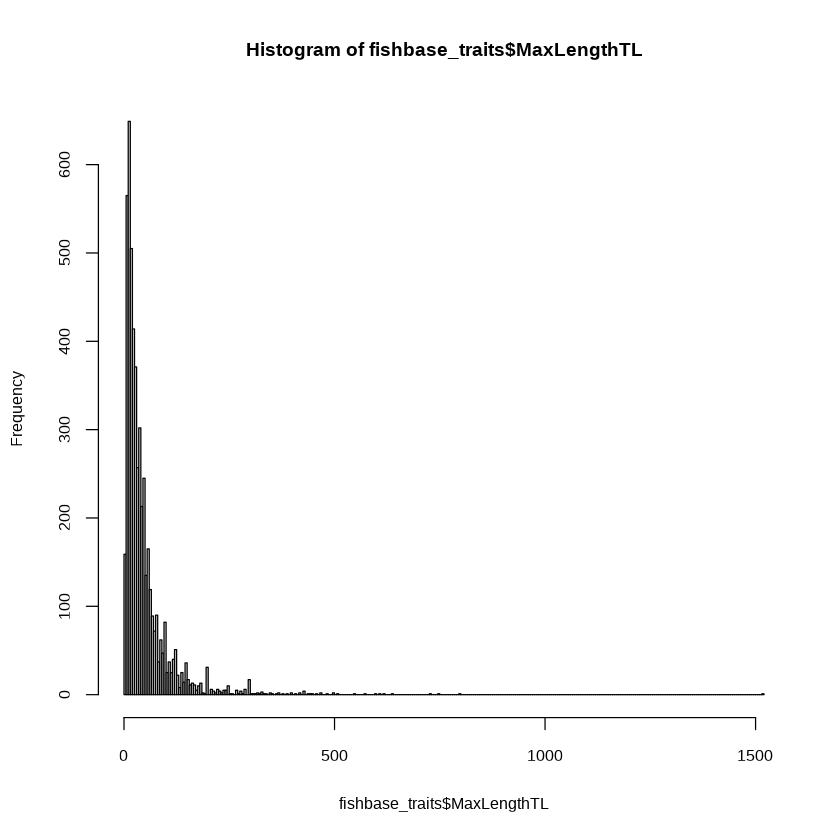

In [5]:
hist(fishbase_traits$MaxLengthTL, breaks = 300)

In [9]:
library(dlookr)
bins <- binning(fishbase_traits$MaxLengthTL, nbins = 12, type = 'quantile')
str(bins)
saveRDS(bins, 'output/maxLengthTL_bins.rds')

 Ord.factor w/ 12 levels "[1.83,8]"<"(8,11.5]"<..: 10 3 3 12 6 4 4 4 5 5 ...
 - attr(*, "type")= chr "quantile"
 - attr(*, "breaks")= num [1:13] 1.83 8 11.5 15 19.01 ...
 - attr(*, "raw")= num [1:5106] 60 13 15 140 30 ...


In [8]:
bins_troph <- dlookr::binning(fishbase_traits$Troph, nbins = 12, type = 'quantile')
str(bins_troph)
saveRDS(bins_troph, 'output/Troph_bins.rds')

Warning message in load_default_font():
“the temporary directory /tmp/Rtmp5Dl5sG does not have write permission,
failed to load the 'WenQuanYi Micro Hei' font”


 Ord.factor w/ 12 levels "[2,2.69]"<"(2.69,3.07]"<..: 6 11 3 12 2 3 1 2 10 2 ...
 - attr(*, "type")= chr "quantile"
 - attr(*, "breaks")= num [1:13] 2 2.69 3.07 3.24 3.34 ...
 - attr(*, "raw")= num [1:5106] 3.43 4.2 3.22 4.5 3.02 ...


In [7]:
inters <- filter(fishbase_traits, is.na(trophic_group)) %>% 
    left_join(traits_AtlPaci, by = c('Species' = 'taxon')) %>% 
    filter(!is.na(feeding.mode))
length(unique(inters$Species)) # number of species in the atlpaci

[1] 315

# traits interpolation

## phylopars

In [8]:
library(ape)
# tree <- read.tree('TraitsCollection/actinopt_12k_treePL.tre.xz')
tree <- read.tree('TraitsCollection/actinopt_full.trees.xz')

In [9]:
species_without_temp <- filter(fishbase_traits, is.na(TempPrefMean)) %>% pull(Species)
species_without_temp <- gsub(' ', '_', species_without_temp)
n_distinct(species_without_temp) # number of species without 'TempPrefMean' traits

[1] 397

In [10]:
intersect(species_without_temp, tree[[1]]$tip.label) %>% n_distinct() # species without TempPrefMean but in tree

[1] 319

In [11]:
tree[[1]]


Phylogenetic tree with 31516 tips and 31515 internal nodes.

Tip labels:
  Polypterus_ornatipinnis, Polypterus_weeksii, Polypterus_mokelembembe, Polypterus_retropinnis, Polypterus_congicus, Polypterus_ansorgii, ...

Rooted; includes branch lengths.

In [ ]:
# imputed with phylogeny
library(Rphylopars)
library(picante)

fishbase_traits$Species <- gsub(' ', '_', fishbase_traits$Species)
subtraits <- column_to_rownames(fishbase_traits, var = 'Species')

matched <- picante::match.phylo.data(tree[[1]], subtraits)
matched$data_sub <- select(matched$data, TempPrefMean) %>% 
                mutate_all(as.numeric) %>% tibble::rownames_to_column('species')
                    
p_BM <- phylopars(trait_data = matched$data_sub, tree = matched$phy)

In [13]:
nrow(matched$data_sub)
nrow(p_BM$anc_recon)

imputed <- as.data.frame(p_BM$anc_recon[1:4488,]) %>% tibble::rownames_to_column('Species') %>%
    rename('TempPrefMean_imputed' = 'p_BM$anc_recon[1:4488, ]')
traits_imputed <- filter(fishbase_traits, !(Species %in% imputed$Species)) %>% select(Species, TempPrefMean) %>%
    rename('TempPrefMean_imputed' = 'TempPrefMean') %>% bind_rows(imputed)
summary(traits_imputed)
fishbase_traits_imputed <- left_join(fishbase_traits, traits_imputed, by = c('Species'))

[1] 4488

[1] 8975

   Species          TempPrefMean_imputed
 Length:5106        Min.   :-1.70       
 Class :character   1st Qu.:14.20       
 Mode  :character   Median :24.60       
                    Mean   :20.37       
                    3rd Qu.:27.60       
                    Max.   :29.00       
                    NA's   :78          

## genus mean

In [14]:
# fill NA with the mean values within the same genus and #family
pattern_genus = '[A-Z][a-z]+(?=_)'
pattern_fam <- '(?<=\\|)[A-Z][a-z]+idae'
family <- str_extract(taxa_verified_table$ClassificationPath, pattern = pattern_fam)
pattern_species = '[A-Z][a-z]+\\s[a-z]+$'
Species <- str_extract(taxa_verified_table$ClassificationPath, pattern = pattern_species) %>% 
    gsub(' ', '_', .)
taxon <- data.frame(Species = Species, family = family) # extract family, genus, and species

fishbase_traits_imputed$genus <- str_extract(fishbase_traits_imputed$Species, pattern = pattern_genus)
fishbase_traits_imputed <- left_join(fishbase_traits_imputed, taxon, by = 'Species')

fishbase_traits_imputed <- group_by(fishbase_traits_imputed, genus) %>%
    mutate(TempPrefMean_imputed = replace_na(TempPrefMean_imputed, mean(TempPrefMean_imputed, na.rm = TRUE)),
          MaxLengthTL = replace_na(MaxLengthTL, mean(MaxLengthTL, na.rm = TRUE)),
          Troph = replace_na(Troph, mean(Troph, na.rm = TRUE)))

# fishbase_traits_imputed <- group_by(fishbase_traits_imputed, family) %>%
#     mutate(TempPrefMean_imputed = replace_na(TempPrefMean_imputed, mean(TempPrefMean_imputed, na.rm = TRUE)))
summary(fishbase_traits_imputed)

   Species           MaxLengthTL          Troph        ComDepthMin     
 Length:5323        Min.   :   1.83   Min.   :2.000   Min.   :   0.00  
 Class :character   1st Qu.:  15.00   1st Qu.:3.240   1st Qu.:   4.00  
 Mode  :character   Median :  30.00   Median :3.490   Median :  11.00  
                    Mean   :  48.31   Mean   :3.462   Mean   :  85.62  
                    3rd Qu.:  56.00   3rd Qu.:3.810   3rd Qu.:  55.00  
                    Max.   :1520.00   Max.   :4.940   Max.   :3037.00  
                                                      NA's   :287      
  ComDepthMax      TempPrefMean    FeedingPath    age.maturity   
 Min.   :   0.0   Min.   :-1.70   benthic:3313   Min.   : 0.000  
 1st Qu.:  18.0   1st Qu.:14.03   pelagic:1947   1st Qu.: 2.028  
 Median :  40.0   Median :24.90   NA's   :  63   Median : 3.500  
 Mean   : 181.8   Mean   :20.41                  Mean   : 4.531  
 3rd Qu.: 161.0   3rd Qu.:27.70                  3rd Qu.: 5.482  
 Max.   :3834.0   Max.   :29

## gbif occurrence calculation

In [12]:
filter(fishbase_traits_imputed, is.na(TempPrefMean_imputed))
species_without_tempPref <- filter(fishbase_traits_imputed, is.na(TempPrefMean_imputed)) %>% pull(Species) %>% gsub('_', ' ', .)

Species,MaxLengthTL,Troph,ComDepthMin,ComDepthMax,TempPrefMean,FeedingPath,age.maturity,fecundity,offspring.size,diet_breadth,trophic_group,TempPrefMean_imputed,genus,family
<chr>,<dbl>,<dbl>,<int>,<int>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<int>,<chr>,<dbl>,<chr>,<chr>
Percalates_novemaculeatus,60,3.41,NA,NA,NA,benthic,NA,NA,NA,0,NA,NaN,Percalates,Percichthyidae


In [6]:
library(ncdf4)
ncfile <- 'TraitsCollection/woa18_decav_t00_01.nc'
nc_data <- ncdf4::nc_open(ncfile)
names(nc_data$var)

depth <- ncvar_get(nc_data, "depth")

t_an.array <- ncvar_get(nc_data, "t_an") # store the data in a 3-dimensional array
dim(t_an.array) # 102 depth series
fillvalue <- ncatt_get(nc_data, "t_an", "_FillValue")
fillvalue

nc_close(nc_data)
t_an.array[t_an.array == fillvalue$value] <- NA

[1] "crs"                "lat_bnds"           "lon_bnds"          
 [4] "depth_bnds"         "climatology_bounds" "t_an"              
 [7] "t_mn"               "t_dd"               "t_sd"              
[10] "t_se"               "t_oa"               "t_gp"

[1] 360 180 102

$hasatt
[1] TRUE

$value
[1] 9.96921e+36

In [7]:
head(depth)

[1]  0  5 10 15 20 25

In [8]:
temp_raster <- raster::brick(ncfile, varname = 't_an')
dim(temp_raster)

[1] 180 360 102

In [9]:
# calculated mean preferred temperature from gbif
library(rgbif)
gbif_downloading <- function(species){
    key <- name_backbone(species)
    d1 <- occ_download(
        user = 'huangmp',
        pwd = 'pan31415926',
        email = 'huangmingpan@ioz.ac.cn',
        type = "and",
        pred("taxonKey", key$usageKey),
        pred("hasCoordinate", TRUE),
        pred_gte("year", 1970),
        pred("hasGeospatialIssue", FALSE),
        format = "SIMPLE_CSV"
    )
    occ <- occ_download_get(d1, path = "./TraitsCollection/occ_download/", overwrite = TRUE) %>% occ_download_import()
    return(occ)
}

In [10]:
tempPrefMean_calculating <- function(occ){
    temp_result <- c()
    for (i in 1:nrow(occ)){
        if (!is.na(occ$depth[i])){ # NA depth
            depth_level <- abs(occ$depth[i] - depth) %>% which.min()
        }else{
            depth_level <- 1
             }
        rasterlayer <- raster::raster(temp_raster, depth_level)
        xy <- cbind(occ$decimalLongitude[i], occ$decimalLatitude[i])
        temp <- raster::extract(rasterlayer, xy)
        temp_result <- append(temp_result, temp)
    }
    temp_mean <- mean(temp_result, na.rm = TRUE)
    return(temp_mean)
}

In [ ]:
for (species in species_without_tempPref){
    # species <- 'Aulohalaelurus labiosus'
    print(species)
    attempts <- 0
    success <- FALSE
    while (!success & attempts < 20){
        tryCatch({
            occ <- gbif_downloading(species)
            temp_mean <- tempPrefMean_calculating(occ)
            spname <- gsub(' ', '_', species)
            fishbase_traits_imputed$TempPrefMean_imputed[which(fishbase_traits_imputed$Species == spname)] <- temp_mean
            success <- TRUE
            }, error = function(e){
                print('retrying...')
                attempts <- attempts + 1
                }
                 )
        }
}

In [4]:
# write.csv(fishbase_traits_imputed, 'TraitsCollection/fishbase_traits_imputed.csv', row.names = F)
fishbase_traits_imputed <- read.csv('TraitsCollection/fishbase_traits_imputed.csv')

In [4]:
# deleted a freshwater fish species
fishbase_traits_final <- filter(fishbase_traits_imputed, Species != 'Percalates_novemaculeatus') %>%
    select("Species", "MaxLengthTL", "Troph", "TempPrefMean_imputed", "genus", "family")
fishbase_traits_final$Species <- gsub('_', ' ', fishbase_traits_final$Species)

## VIF between traits

In [7]:
library(spatialRF)
vif_values <- vif(dplyr::select(fishbase_traits_imputed, MaxLengthTL, Troph, TempPrefMean_imputed))
head(vif_values)

,variable,vif
,<chr>,<dbl>
1,Troph,1.191
2,MaxLengthTL,1.154
3,TempPrefMean_imputed,1.049


# fit model

## Biotime

### deal with unidentified fish in the dataset

In [155]:
pattern_tip = '[^\\|]+$'
taxa_verified_table$binomial <- str_extract(taxa_verified_table$ClassificationPath, pattern = pattern_tip)

In [156]:
head(biotime_selected)

,STUDY_ID,grid,YEAR,coverage,species_richness,year_span,ABUNDANCE,BIOMASS,LATITUDE,LONGITUDE,PLOT,DEPTH,SAMPLE_DESC,GENUS_SPECIES
,<int>,<int>,<int>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<chr>
1,45,5269674,2006,0.8550883,220,9,1,22.40,-17.5,-149,1,0,-17.5_-149_LTER_1_Backreef_Fish_Transect_1_Swath_5_m_12_7_2006,Abudefduf septemfasciatus
2,45,5269674,2006,0.8550883,220,9,2,60.30,-17.5,-149,1,0,-17.5_-149_LTER_1_Backreef_Fish_Transect_1_Swath_5_m_12_7_2006,Abudefduf septemfasciatus
3,45,5269674,2006,0.8550883,220,9,1,22.40,-17.5,-149,4,0,-17.5_-149_LTER_1_Backreef_Fish_Transect_4_Swath_5_m_12_7_2006,Abudefduf septemfasciatus
4,45,5269674,2006,0.8550883,220,9,1,30.10,-17.5,-149,1,0,-17.5_-149_LTER_3_Backreef_Fish_Transect_1_Swath_5_m_16_7_2006,Abudefduf septemfasciatus
5,45,5269674,2006,0.8550883,220,9,1,140.90,-17.5,-149,2,0,-17.5_-149_LTER_6_Fringing_Reef_Fish_Transect_2_Swath_5_m_12_7_2006,Abudefduf septemfasciatus
6,45,5269674,2006,0.8550883,220,9,5,24.19,-17.5,-149,1,0,-17.5_-149_LTER_1_Backreef_Fish_Transect_1_Swath_5_m_12_7_2006,Abudefduf sexfasciatus


In [157]:
biotime_traits <- left_join(biotime_selected, select(taxa_verified_table, ScientificName, binomial),
                            by = c('GENUS_SPECIES' = 'ScientificName')) %>%
    left_join(fishbase_traits_final, by = c('binomial' = 'Species'))
biotime_traits$binomial <- coalesce(biotime_traits$binomial, biotime_traits$GENUS_SPECIES)
head(biotime_traits)

,STUDY_ID,grid,YEAR,coverage,species_richness,year_span,ABUNDANCE,BIOMASS,LATITUDE,LONGITUDE,PLOT,DEPTH,SAMPLE_DESC,GENUS_SPECIES,binomial,MaxLengthTL,Troph,TempPrefMean_imputed,genus,family
,<int>,<int>,<int>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1,45,5269674,2006,0.8550883,220,9,1,22.40,-17.5,-149,1,0,-17.5_-149_LTER_1_Backreef_Fish_Transect_1_Swath_5_m_12_7_2006,Abudefduf septemfasciatus,Abudefduf septemfasciatus,23,3.01,28.6,Abudefduf,Pomacentridae
2,45,5269674,2006,0.8550883,220,9,2,60.30,-17.5,-149,1,0,-17.5_-149_LTER_1_Backreef_Fish_Transect_1_Swath_5_m_12_7_2006,Abudefduf septemfasciatus,Abudefduf septemfasciatus,23,3.01,28.6,Abudefduf,Pomacentridae
3,45,5269674,2006,0.8550883,220,9,1,22.40,-17.5,-149,4,0,-17.5_-149_LTER_1_Backreef_Fish_Transect_4_Swath_5_m_12_7_2006,Abudefduf septemfasciatus,Abudefduf septemfasciatus,23,3.01,28.6,Abudefduf,Pomacentridae
4,45,5269674,2006,0.8550883,220,9,1,30.10,-17.5,-149,1,0,-17.5_-149_LTER_3_Backreef_Fish_Transect_1_Swath_5_m_16_7_2006,Abudefduf septemfasciatus,Abudefduf septemfasciatus,23,3.01,28.6,Abudefduf,Pomacentridae
5,45,5269674,2006,0.8550883,220,9,1,140.90,-17.5,-149,2,0,-17.5_-149_LTER_6_Fringing_Reef_Fish_Transect_2_Swath_5_m_12_7_2006,Abudefduf septemfasciatus,Abudefduf septemfasciatus,23,3.01,28.6,Abudefduf,Pomacentridae
6,45,5269674,2006,0.8550883,220,9,5,24.19,-17.5,-149,1,0,-17.5_-149_LTER_1_Backreef_Fish_Transect_1_Swath_5_m_12_7_2006,Abudefduf sexfasciatus,Abudefduf sexfasciatus,19,2.70,28.4,Abudefduf,Pomacentridae


In [183]:
fill_na_with_taxon_mean <- function(table){
    # genus mean of traits
    genus_table <- filter(table, !is.na(TempPrefMean_imputed)) %>%
        group_by(genus) %>% summarise(MaxLengthTL_mean = mean(MaxLengthTL),
                                     Troph_mean = mean(Troph),
                                     temp_mean = mean(TempPrefMean_imputed)) %>% rename('taxon' = 'genus')
    # family mean of traits
    family_table <- filter(table, !is.na(TempPrefMean_imputed)) %>%
        group_by(family) %>% summarise(MaxLengthTL_mean = mean(MaxLengthTL),
                                     Troph_mean = mean(Troph),
                                     temp_mean = mean(TempPrefMean_imputed)) %>% rename('taxon' = 'family')
    taxon_temp <- rbind(genus_table, family_table)
    # NA replace with the taxon from the same grid
    result_table <- left_join(table, taxon_temp, by = c('binomial' = 'taxon')) %>%
        mutate(TempPrefMean_imputed = coalesce(TempPrefMean_imputed, temp_mean),
               Troph = coalesce(Troph, Troph_mean),
               MaxLengthTL = coalesce(MaxLengthTL, MaxLengthTL_mean),
               .keep = 'unused')
    return(result_table)
}

In [159]:
biotime_traits_imputed <- group_by(biotime_traits, STUDY_ID, grid) %>% group_split() %>% lapply(fill_na_with_taxon_mean)
biotime_traits_imputed <- data.frame(Reduce(rbind, biotime_traits_imputed))

In [1]:
summary(biotime_traits_imputed)

ERROR: Error in summary(biotime_traits_imputed): object 'biotime_traits_imputed' not found


In [167]:
# write.csv(biotime_traits_imputed, 'biotime_traits_imputed.csv', row.names = F)

## RLS

In [180]:
rls_traits <- left_join(rls_selected, select(taxa_verified_table, ScientificName, binomial),
                            by = c('species_name' = 'ScientificName')) %>%
    rename(family_origin = family) %>% 
    left_join(fishbase_traits_final, by = c('binomial' = 'Species'))
rls_traits$binomial <- coalesce(rls_traits$binomial, rls_traits$species_name)
head(rls_traits)

,grid,year,coverage,species_richness,year_span,FID,survey_id,country,area,ecoregion,⋯,geom,ymd,point_lon,point_lat,binomial,MaxLengthTL,Troph,TempPrefMean_imputed,genus,family
,<int>,<int>,<dbl>,<int>,<int>,<chr>,<int>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1,1083749,2015,0.9990102,29,5,ep_m1_public_data.fid--29c2dffb_17dfef00c04_-a17,912349440,Morocco,Morocco,Alboran Sea,⋯,POINT (-3.890000104904175 35.209999084472656),2015-01-10,-3.89,35.21,Coris julis,36.60,3.44,19.0,Coris,Labridae
2,1083749,2015,0.9990102,29,5,ep_m1_public_data.fid--29c2dffb_17dfef00c04_-a16,912349440,Morocco,Morocco,Alboran Sea,⋯,POINT (-3.890000104904175 35.209999084472656),2015-01-10,-3.89,35.21,Coris julis,36.60,3.44,19.0,Coris,Labridae
3,1083749,2015,0.9990102,29,5,ep_m1_public_data.fid--29c2dffb_17dfef00c04_-a15,912349440,Morocco,Morocco,Alboran Sea,⋯,POINT (-3.890000104904175 35.209999084472656),2015-01-10,-3.89,35.21,Symphodus tinca,53.68,3.25,18.9,Symphodus,Labridae
4,1083749,2015,0.9990102,29,5,ep_m1_public_data.fid--29c2dffb_17dfef00c04_-a14,912349440,Morocco,Morocco,Alboran Sea,⋯,POINT (-3.890000104904175 35.209999084472656),2015-01-10,-3.89,35.21,Symphodus tinca,53.68,3.25,18.9,Symphodus,Labridae
5,1083749,2015,0.9990102,29,5,ep_m1_public_data.fid--29c2dffb_17dfef00c04_-a13,912349440,Morocco,Morocco,Alboran Sea,⋯,POINT (-3.890000104904175 35.209999084472656),2015-01-10,-3.89,35.21,Symphodus tinca,53.68,3.25,18.9,Symphodus,Labridae
6,1083749,2015,0.9990102,29,5,ep_m1_public_data.fid--29c2dffb_17dfef00c04_-a12,912349440,Morocco,Morocco,Alboran Sea,⋯,POINT (-3.890000104904175 35.209999084472656),2015-01-10,-3.89,35.21,Thalassoma pavo,30.50,3.50,18.7,Thalassoma,Labridae


In [ ]:
colnames(rls_traits)

In [193]:
rls_traits_imputed <- group_by(rls_traits, grid) %>% group_split() %>% lapply(fill_na_with_taxon_mean)
rls_traits_imputed <- data.frame(Reduce(rbind, rls_traits_imputed))

In [194]:
write.csv(rls_traits_imputed, 'rls_traits_imputed.csv', row.names = F)

In [195]:
summary(rls_traits_imputed)

      grid              year         coverage      species_richness
 Min.   :1083749   Min.   :1992   Min.   :0.8504   Min.   :  4.0   
 1st Qu.:4544794   1st Qu.:2010   1st Qu.:0.9427   1st Qu.: 54.0   
 Median :4633047   Median :2014   Median :0.9610   Median :112.0   
 Mean   :4562592   Mean   :2013   Mean   :0.9534   Mean   :115.9   
 3rd Qu.:4651315   3rd Qu.:2018   3rd Qu.:0.9747   3rd Qu.:169.0   
 Max.   :5120011   Max.   :2021   Max.   :1.0000   Max.   :270.0   
                                                                   
   year_span         FID              survey_id           country         
 Min.   : 5.00   Length:1098878     Min.   :  2000854   Length:1098878    
 1st Qu.: 8.00   Class :character   1st Qu.:812310114   Class :character  
 Median :13.00   Mode  :character   Median :912344193   Mode  :character  
 Mean   :13.93                      Mean   :735680543                     
 3rd Qu.:16.00                      3rd Qu.:912350593                     
 Max. 

## obis

In [213]:
obis_data_files <- list.files('obis_download/data_coverage/data_slim/')
head(obis_data_files)

[1] "Abundance of Rocky Reef Fishes, Invertebrates and Algae, Reef Check California (RCCA), 2006 - 2017.csv"                                                   
[2] "Australian Institute of Marine Science (AIMS) - Baited Remote Underwater Video Station (BRUVS), Australia (1999 to present).csv"                          
[3] "Australian Institute of Marine Science (AIMS) Long-term Monitoring Program: Visual Census Fish Data (Great Barrier Reef), Australia (1992 to present).csv"
[4] "Australian Museums Lizard Island Research Station, Queensland, Australia (1900 - 2018).csv"                                                               
[5] "Bottom Trawl Surveys: Catch and Effort Data For South East Australia, 1898-1996.csv"                                                                      
[6] "Canadian Field-Naturalist: Fishes stranded during extreme Iow tides in Minas Basin, Nova Scotia.csv"

In [248]:
# bind datasets
obis_data <- data.frame()
for (i in obis_data_files){
    data <- read.csv(paste0('obis_download/data_coverage/data_slim/', i))
    meta <- read.csv(paste0('obis_download/data_coverage/sample_table/', i))
    meta_selected <- filter(meta, year_span > 4, coverage >= 0.85)
    data_filtered <- filter(data, grid %in% meta_selected$grid, date_year %in% meta_selected$date_year) %>% 
        mutate(dataset_name = rep(i, nrow(.)))
    obis_data <- bind_rows(obis_data, data_filtered)
}

### delete datasets with too much NA abundance

In [249]:
# NA values distribution of 'abundance'
na_abund_table <- mutate(obis_data, abundance = na_if(abundance, -9), abundance = na_if(abundance, 0)) %>%
    filter(is.na(abundance)) %>%
    pull(dataset_name) %>%
    table() %>% as.data.frame()
colnames(na_abund_table) <- c('dataset_name', 'Freq')
na_abund_table$path <- paste0('obis_download/data_coverage/data_slim/', na_abund_table$dataset_name)
head(na_abund_table)

,dataset_name,Freq,path
,<fct>,<int>,<chr>
1,"Bottom Trawl Surveys: Catch and Effort Data For South East Australia, 1898-1996.csv",614,"obis_download/data_coverage/data_slim/Bottom Trawl Surveys: Catch and Effort Data For South East Australia, 1898-1996.csv"
2,Catch data from New Zealand research trawls since 2008.csv,646,obis_download/data_coverage/data_slim/Catch data from New Zealand research trawls since 2008.csv
3,"CSIRO, North West Shelf Demersal Marine Resources Study 1980-1997.csv",59757,"obis_download/data_coverage/data_slim/CSIRO, North West Shelf Demersal Marine Resources Study 1980-1997.csv"
4,"CSIRO, Soviet Fishery Data, Australia, 1965-1978.csv",7516,"obis_download/data_coverage/data_slim/CSIRO, Soviet Fishery Data, Australia, 1965-1978.csv"
5,Epibenthos and demersal fish monitoring at long-term monitoring stations in the Belgian part of the North Sea.csv,586,obis_download/data_coverage/data_slim/Epibenthos and demersal fish monitoring at long-term monitoring stations in the Belgian part of the North Sea.csv
6,ICES Baltic International Trawl Survey for commercial fish species.csv,271,obis_download/data_coverage/data_slim/ICES Baltic International Trawl Survey for commercial fish species.csv


In [250]:
na_abund_table$observation_num <- lapply(na_abund_table$path, read.csv) %>% lapply(nrow) %>% unlist()
na_abund_table <- mutate(na_abund_table, na_percent = Freq/observation_num)

In [251]:
na_abund_table

dataset_name,Freq,path,observation_num,na_percent
<fct>,<int>,<chr>,<int>,<dbl>
"Bottom Trawl Surveys: Catch and Effort Data For South East Australia, 1898-1996.csv",614,"obis_download/data_coverage/data_slim/Bottom Trawl Surveys: Catch and Effort Data For South East Australia, 1898-1996.csv",13820,4.442836e-02
Catch data from New Zealand research trawls since 2008.csv,646,obis_download/data_coverage/data_slim/Catch data from New Zealand research trawls since 2008.csv,92707,6.968190e-03
"CSIRO, North West Shelf Demersal Marine Resources Study 1980-1997.csv",59757,"obis_download/data_coverage/data_slim/CSIRO, North West Shelf Demersal Marine Resources Study 1980-1997.csv",186698,3.200731e-01
"CSIRO, Soviet Fishery Data, Australia, 1965-1978.csv",7516,"obis_download/data_coverage/data_slim/CSIRO, Soviet Fishery Data, Australia, 1965-1978.csv",117871,6.376462e-02
Epibenthos and demersal fish monitoring at long-term monitoring stations in the Belgian part of the North Sea.csv,586,obis_download/data_coverage/data_slim/Epibenthos and demersal fish monitoring at long-term monitoring stations in the Belgian part of the North Sea.csv,4713,1.243369e-01
ICES Baltic International Trawl Survey for commercial fish species.csv,271,obis_download/data_coverage/data_slim/ICES Baltic International Trawl Survey for commercial fish species.csv,768517,3.526272e-04
ICES Beam Trawl Survey for commercial fish species.csv,453,obis_download/data_coverage/data_slim/ICES Beam Trawl Survey for commercial fish species.csv,383266,1.181947e-03
ICES North Sea International Bottom Trawl Survey for commercial fish species.csv,1033,obis_download/data_coverage/data_slim/ICES North Sea International Bottom Trawl Survey for commercial fish species.csv,2932706,3.522344e-04
Irish Ground Fish Survey for commercial fish species.csv,16,obis_download/data_coverage/data_slim/Irish Ground Fish Survey for commercial fish species.csv,160681,9.957618e-05


In [254]:
obis_data <- filter(obis_data, ! (dataset_name %in% na_abund_table$dataset_name[which(na_abund_table$na_percent > 0.1)])) %>% 
    mutate(abundance = na_if(abundance, -9), abundance = na_if(abundance, 0))

In [257]:
summary(obis_data)

   date_year    scientificName     decimalLongitude   decimalLatitude 
 Min.   :1909   Length:9025484     Min.   :-179.910   Min.   :-67.01  
 1st Qu.:1995   Class :character   1st Qu.: -80.828   1st Qu.: 24.97  
 Median :2002   Mode  :character   Median :  -4.046   Median : 51.61  
 Mean   :2001                      Mean   : -33.664   Mean   : 39.58  
 3rd Qu.:2009                      3rd Qu.:   4.383   3rd Qu.: 56.29  
 Max.   :2019                      Max.   : 179.980   Max.   : 74.00  
                                                                      
   abundance             grid         dataset_name      
 Min.   :       0   Min.   :      1   Length:9025484    
 1st Qu.:       1   1st Qu.: 545919   Class :character  
 Median :      15   Median : 618836   Mode  :character  
 Mean   :    3397   Mean   :1544998                     
 3rd Qu.:     186   3rd Qu.:2703093                     
 Max.   :71842400   Max.   :5214585                     
 NA's   :11790                   

### traits assign & delete datasets with too much NA traits

In [260]:
obis_traits <- left_join(obis_data, select(taxa_verified_table, ScientificName, binomial),
                         by = c('scientificName' = 'ScientificName')) %>% 
    left_join(fishbase_traits_final, by = c('binomial' = 'Species')) %>% 
    mutate(binomial = coalesce(binomial, scientificName))
summary(obis_traits)

   date_year    scientificName     decimalLongitude   decimalLatitude 
 Min.   :1909   Length:9347399     Min.   :-179.910   Min.   :-67.01  
 1st Qu.:1995   Class :character   1st Qu.: -80.943   1st Qu.: 24.92  
 Median :2003   Mode  :character   Median :  -4.262   Median : 51.31  
 Mean   :2001                      Mean   : -33.835   Mean   : 39.20  
 3rd Qu.:2009                      3rd Qu.:   4.367   3rd Qu.: 56.23  
 Max.   :2019                      Max.   : 179.980   Max.   : 74.00  
                                                                      
   abundance             grid         dataset_name         binomial        
 Min.   :       0   Min.   :      1   Length:9347399     Length:9347399    
 1st Qu.:       1   1st Qu.: 546005   Class :character   Class :character  
 Median :      14   Median : 623283   Mode  :character   Mode  :character  
 Mean   :    3282   Mean   :1568158                                        
 3rd Qu.:     171   3rd Qu.:2703093                 

In [261]:
obis_traits_imputed <- group_by(obis_traits, dataset_name, grid) %>% group_split() %>% lapply(fill_na_with_taxon_mean)
obis_traits_imputed <- data.frame(Reduce(rbind, obis_traits_imputed))

In [265]:
summary(obis_traits_imputed)
# saveRDS(obis_traits_imputed, 'obis_traits_imputed.rds')

   date_year    scientificName     decimalLongitude   decimalLatitude 
 Min.   :1909   Length:9347399     Min.   :-179.910   Min.   :-67.01  
 1st Qu.:1995   Class :character   1st Qu.: -80.943   1st Qu.: 24.92  
 Median :2003   Mode  :character   Median :  -4.262   Median : 51.31  
 Mean   :2001                      Mean   : -33.835   Mean   : 39.20  
 3rd Qu.:2009                      3rd Qu.:   4.367   3rd Qu.: 56.23  
 Max.   :2019                      Max.   : 179.980   Max.   : 74.00  
                                                                      
   abundance             grid         dataset_name         binomial        
 Min.   :       0   Min.   :      1   Length:9347399     Length:9347399    
 1st Qu.:       1   1st Qu.: 546005   Class :character   Class :character  
 Median :      14   Median : 623283   Mode  :character   Mode  :character  
 Mean   :    3282   Mean   :1568158                                        
 3rd Qu.:     171   3rd Qu.:2703093                 

### NA traits

In [2]:
# obis_traits_imputed <- readRDS('obis_traits_imputed.rds')

In [5]:
na_traits_table <- filter(obis_traits_imputed, is.na(Troph)) %>% pull(dataset_name) %>% table() %>% as.data.frame() %>%
    arrange(desc(Freq))
colnames(na_traits_table) <- c('dataset_name', 'Freq')
na_traits_table$path <- paste0('obis_download/data_coverage/data_slim/', na_traits_table$dataset_name)

In [6]:
na_traits_table$observation_num <- lapply(na_traits_table$path, read.csv) %>% lapply(nrow) %>% unlist()
na_traits_table <- mutate(na_traits_table, na_percent = Freq/observation_num)

In [7]:
arrange(na_traits_table, desc(na_percent)) %>% head(n = 10)
# dataset whose abundance was biomass
datasetname_excluding <- c('Catch data from New Zealand research trawls since 2008.csv',
                         'Marine biodiversity atlas of the Balearic Sea.csv',
                          'IMR Capelin larvae monitoring.csv')
obis_traits_imputed <- filter(obis_traits_imputed,
                              ! (dataset_name %in% na_traits_table$dataset_name[which(na_traits_table$na_percent > 0.1)]),
                              ! (dataset_name %in% datasetname_excluding))

,dataset_name,Freq,path,observation_num,na_percent
,<fct>,<int>,<chr>,<int>,<dbl>
1,DFO Maritimes Research Vessel Trawl Surveys Fish Observations (OBIS Canada).csv,20,obis_download/data_coverage/data_slim/DFO Maritimes Research Vessel Trawl Surveys Fish Observations (OBIS Canada).csv,38,0.52631579
2,Gulf of Riga Larval Fish Survey.csv,950,obis_download/data_coverage/data_slim/Gulf of Riga Larval Fish Survey.csv,2064,0.46027132
3,Interannual variability of ichthyoplankton diversity in the Patos Lagoon estuary Southern Brazil.csv,764,obis_download/data_coverage/data_slim/Interannual variability of ichthyoplankton diversity in the Patos Lagoon estuary Southern Brazil.csv,2162,0.35337650
4,IMOS - Larval Fish Sub-Facility - Database of Marine Larval Fish Assemblages in Australian temperate and subtropical waters (1983 - ongoing).csv,13638,obis_download/data_coverage/data_slim/IMOS - Larval Fish Sub-Facility - Database of Marine Larval Fish Assemblages in Australian temperate and subtropical waters (1983 - ongoing).csv,42570,0.32036646
5,Zooplankton data from central and northern Strait of Georgia.csv,430,obis_download/data_coverage/data_slim/Zooplankton data from central and northern Strait of Georgia.csv,2619,0.16418480
6,"Records of fish species in coastal lagoons and sea shore that belong to Municipality of Preveza, for the period 2002-2011.csv",33,"obis_download/data_coverage/data_slim/Records of fish species in coastal lagoons and sea shore that belong to Municipality of Preveza, for the period 2002-2011.csv",249,0.13253012
7,NOAA AFSC North Pacific Groundfish Observer.csv,33340,obis_download/data_coverage/data_slim/NOAA AFSC North Pacific Groundfish Observer.csv,290023,0.11495640
8,"Rockfish Recruitment and Ecosystem Assessment Survey, Catch Data.csv",1760,"obis_download/data_coverage/data_slim/Rockfish Recruitment and Ecosystem Assessment Survey, Catch Data.csv",27108,0.06492548
9,Multi-decadal shifts in fish community diversity across a dynamic biogeographic transition zone.csv,4913,obis_download/data_coverage/data_slim/Multi-decadal shifts in fish community diversity across a dynamic biogeographic transition zone.csv,114592,0.04287385


In [8]:
library(magrittr)
obis_traits_imputed$abundance[obis_traits_imputed$dataset_name == 'Demersal and mega-benthic species from the MEDITS (Mediterranean International Trawl Survey) project on the Spanish continental shelf between 1994 and 2009.csv']  %<>% 
    ceiling()


Attaching package: ‘magrittr’


The following object is masked from ‘package:purrr’:

    set_names


The following object is masked from ‘package:tidyr’:

    extract




In [9]:
saveRDS(obis_traits_imputed, 'obis_traits_imputed_delete_NA_abund_and_traits.rds')

In [ ]:
# obis_goodness_table <- group_by(obis_table, dataset_name, grid) %>%
#     group_modify(~ broom::glance(lm(TempPref_weighted_mean ~ date_year, data = .x, na.action = na.exclude)))

Warning message in summary.lm(x):
“essentially perfect fit: summary may be unreliable”
Warning message in summary.lm(x):
“essentially perfect fit: summary may be unreliable”
Warning message in summary.lm(x):
“essentially perfect fit: summary may be unreliable”
Warning message in summary.lm(x):
“essentially perfect fit: summary may be unreliable”


In [378]:
# filter(obis_goodness_table, r.squared > 0.99999, nobs > 2)

dataset_name,grid,r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual,nobs
<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>
ICES North Sea International Bottom Trawl Survey for commercial fish species.csv,577343,0.9999976,0.9999952,0.0005512558,413219.9,0.0009903511,1,19.90104,-33.80208,-36.50624,3.038829e-07,1,3
